In [1]:
import zntrack
import matplotlib.pyplot as plt
import numpy as np

In [2]:
volume_scans = [zntrack.from_rev("evaluation_BoxScale")]
volume_scans.extend([zntrack.from_rev(f"evaluation_BoxScale_{x}") for x in range(1, 11)])

2023-08-08 13:04:14,877 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


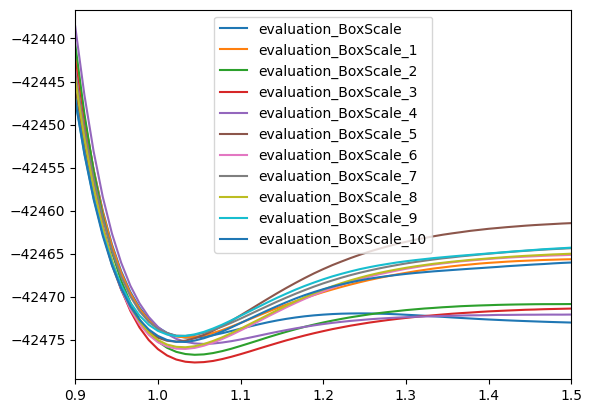

In [3]:
fig, ax = plt.subplots()

for vs in volume_scans:
    energies = [x.get_potential_energy() for x in vs.atoms]

    ax.plot(np.linspace(volume_scans[0].start, volume_scans[0].stop, volume_scans[0].num), energies, label=vs.name)

    # step = (volume_scans[0].stop - volume_scans[0].start) / volume_scans[0].num
    # # add a cross at the minimum

    # ax.plot(
    #     volume_scans[0].start + np.argmin(energies) * step, np.min(energies), "x", color="k"
    # )

    # # vertical dashed line at the minimum
    # # ax.axvline(vs_0.start + np.argmin(energies) * step)
    # ax.axvline(1, linestyle="--", color="k")

    ax.set_xlim(0.90, 1.50)
ax.legend()

In [4]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

In [ ]:
metrics = [
    zntrack.from_rev("AL_0_PredictionMetrics"),
    zntrack.from_rev("AL_1_PredictionMetrics"),
    zntrack.from_rev("AL_2_PredictionMetrics"),
    zntrack.from_rev("AL_3_PredictionMetrics"),
    zntrack.from_rev("AL_4_PredictionMetrics"),
    zntrack.from_rev("AL_5_PredictionMetrics"),
]

Text(0, 0.5, 'RMSE / eV/atom/Angstrom')

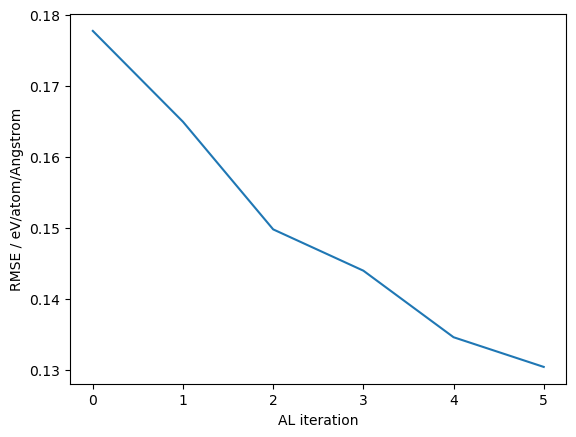

In [ ]:
fig, ax = plt.subplots()
data = [x.forces["rmse"] for x in metrics]
ax.plot(data)
ax.set_xlabel("AL iteration")
ax.set_ylabel("RMSE / eV/atom/Angstrom")